# Chapter 16 - Metric-Predicted Variable on One or Two Groups

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import norm, t
from IPython.display import Image

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('seaborn-v0_8-white')

color = '#87ceeb'

In [3]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn,scipy

matplotlib: 3.10.0
numpy     : 1.26.4
pandas    : 2.2.3
pymc      : 5.16.1
seaborn   : 0.13.2
scipy     : 1.12.0



## Data

In [6]:
df = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Doing_Bayesian_Data_Analysis/data/TwoGroupIQ.csv',
    dtype = {'Group' : 'category'}
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [7]:
df.head()

Score       Group
0    102  Smart Drug
1    107  Smart Drug
2     92  Smart Drug
3    101  Smart Drug
4    110  Smart Drug

In [11]:
(df
 .groupby('Group', observed=False)
 .agg(['mean', 'std'])    
)

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

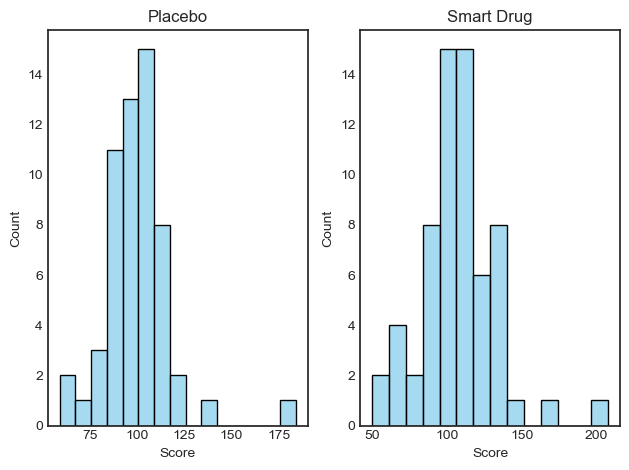

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, group in enumerate(["Placebo", "Smart Drug"]):
    sns.histplot(x="Score", color="#87ceeb", data=df[df["Group"] == group], ax=axes[i])
    axes[i].title.set_text(group)
plt.tight_layout()

In [19]:
y = (df
    .query('Group == "Smart Drug"')
    .filter(['Score'])
    )

## 16.1 - Estimating the mean and standard deviation of a normal distribution

In [22]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sigma = y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)

    likelihood = pm.Normal('likelihood', mu, sigma = sigma, observed = y)

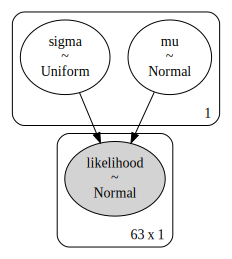

In [23]:
pm.model_to_graphviz(model)

In [24]:
with model:
    idata = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


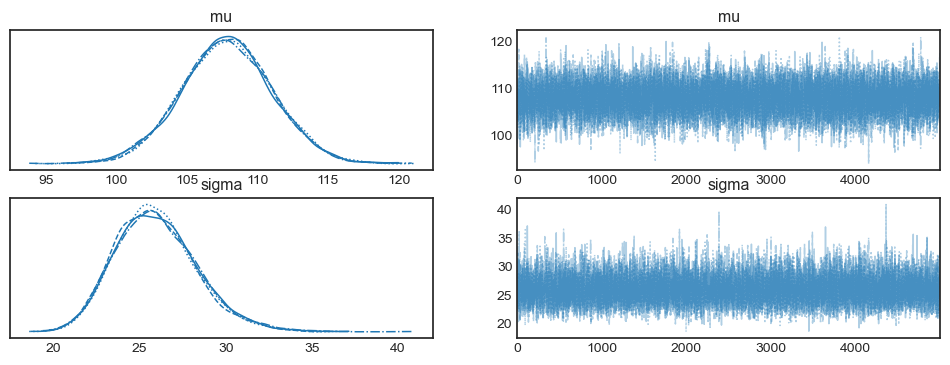

In [25]:
az.plot_trace(idata);

In [27]:
az.summary(idata)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]     107.820  3.244  101.569  113.778      0.024    0.017   18846.0   
sigma[0]   25.958  2.372   21.609   30.406      0.018    0.013   16865.0   

          ess_tail  r_hat  
mu[0]      13448.0    1.0  
sigma[0]   13199.0    1.0

In [28]:
((idata.posterior["mu"] - 100) / idata.posterior["sigma"]).mean()

<xarray.DataArray ()> Size: 8B
array(0.30371609)

In [29]:
# test mu parameter against 100 (definitionally 'average' within the population)
(idata.posterior["mu"] > 100).mean()

<xarray.DataArray 'mu' ()> Size: 8B
array(0.9913)

In [30]:
# test mu parameter against 15 (definitionally the SD of the population)
(idata.posterior["sigma"] > 15).mean()

<xarray.DataArray 'sigma' ()> Size: 8B
array(1.)

In [31]:
# test the standardized effect size against zero
# i.e., what is the probability that the mean is > 0 SDs above 100?
(((idata.posterior['mu']-100)/idata.posterior['sigma']) > 0).mean()

<xarray.DataArray ()> Size: 8B
array(0.9913)

In [32]:
# test effect size against 0.1 (e.g., top of Kruschke's ROPE)
# i.e., what is the probability that the mean is > 0.1 SDs above 100?
(((idata.posterior['mu']-100)/idata.posterior['sigma'])>0.1).mean()

<xarray.DataArray ()> Size: 8B
array(0.9456)

## 16.2 - Outliers and robust estimation: the t distribution

In [33]:
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sigma = y.std())
    sigma = pm.Uniform("sigma", y.std() / 1000, y.std() * 1000)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1 + 1)

    likelihood = pm.StudentT('likelihood', nu, mu, sigma = sigma, observed = y)

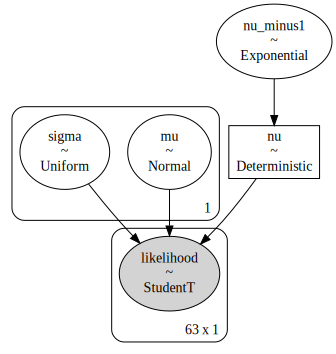

In [34]:
pm.model_to_graphviz(model2)

In [35]:
with model2:
    idata2 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


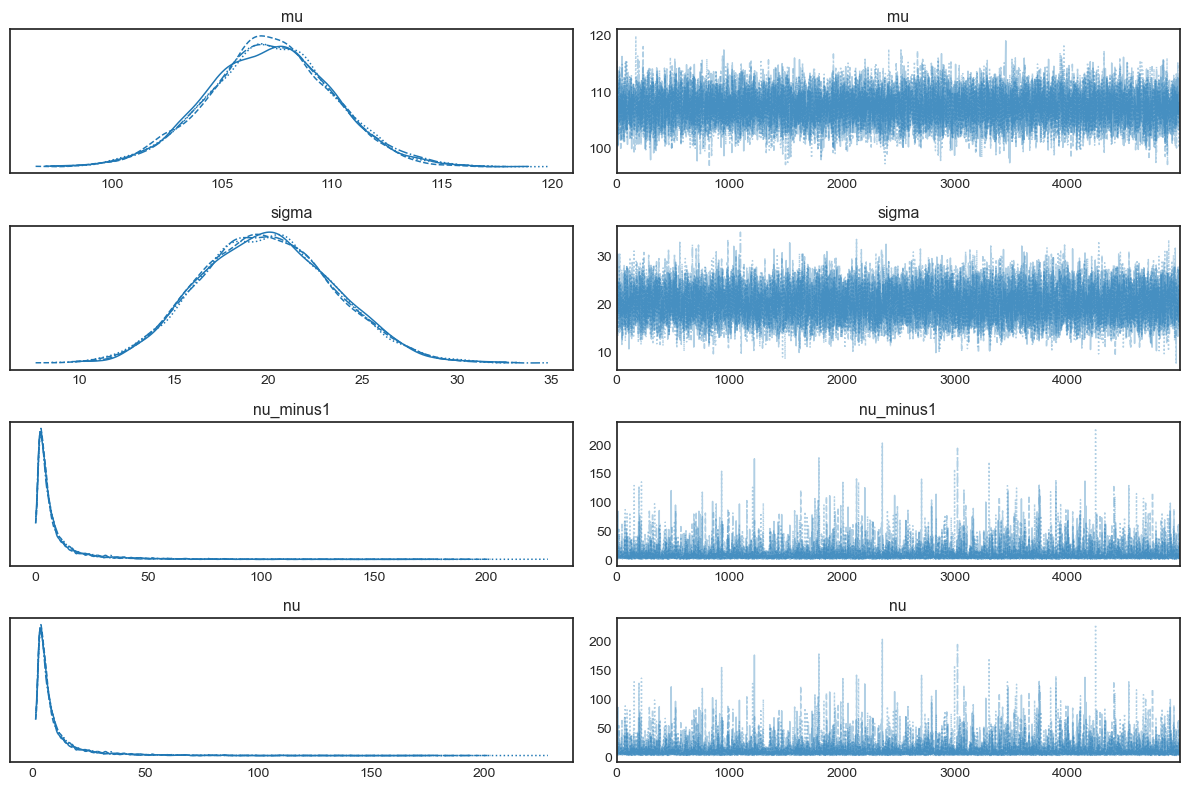

In [36]:
az.plot_trace(idata2)
plt.tight_layout();

In [38]:
az.summary(idata2)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu[0]      107.196   2.846  101.803  112.536      0.028    0.019   10708.0   
sigma[0]    19.938   3.507   13.338   26.331      0.037    0.026    8955.0   
nu_minus1    8.989  13.194    0.128   28.241      0.138    0.098    8748.0   
nu           9.989  13.194    1.128   29.241      0.138    0.098    8748.0   

           ess_tail  r_hat  
mu[0]       11130.0    1.0  
sigma[0]     9746.0    1.0  
nu_minus1   10982.0    1.0  
nu          10982.0    1.0

In [39]:
# test mu parameter against 100 (definitionally 'average' within the population)
(idata2.posterior["mu"] > 100).mean()

<xarray.DataArray 'mu' ()> Size: 8B
array(0.99335)

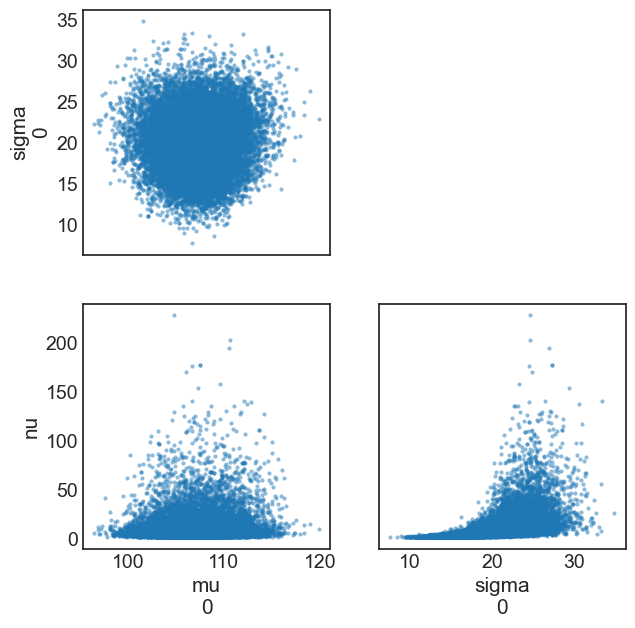

In [40]:
# lower alpha to see where the vast majority of samples are
alpha = 0.5
#alpha = 0.005
az.plot_pair(
    idata2,
    var_names=["mu", "sigma", "nu"],
    scatter_kwargs={"alpha": alpha},
    figsize=(7, 7),
);

## 16.2 - Two Groups

In [41]:
# Index for study groups
grp_idx, grp_codes = pd.factorize(df['Group'])

nr_grps = df['Group'].nunique()

In [42]:
# Coords

coords = {'group':["Smart Drug","Placebo"]}

In [43]:
with pm.Model(coords = coords) as model3:
    # Priors
    mu = pm.Normal(
        'mu',
        df['Score'].mean(),
        sigma = df['Score'].std(),
        dims = 'group'
    )

    sigma = pm.Uniform(
        'sigma',
        df["Score"].std() / 1000, 
        df["Score"].std() * 1000,
        dims = 'group'
    )

    nu_minus1 = pm.Exponential("nu_minus1", 1 / 29)
    nu = pm.Deterministic("nu", nu_minus1 + 1)

    likelihood = pm.StudentT(
        'likelihood',
        nu,
        mu[grp_idx],
        sigma = sigma[grp_idx],
        observed = df['Score']
    )

    

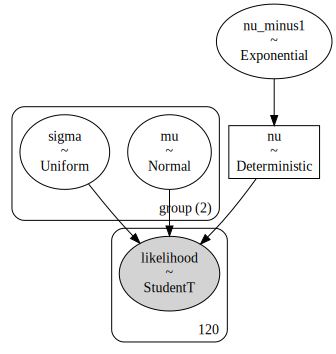

In [44]:
pm.model_to_graphviz(model3)

In [45]:
with model3:
    idata3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu_minus1]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


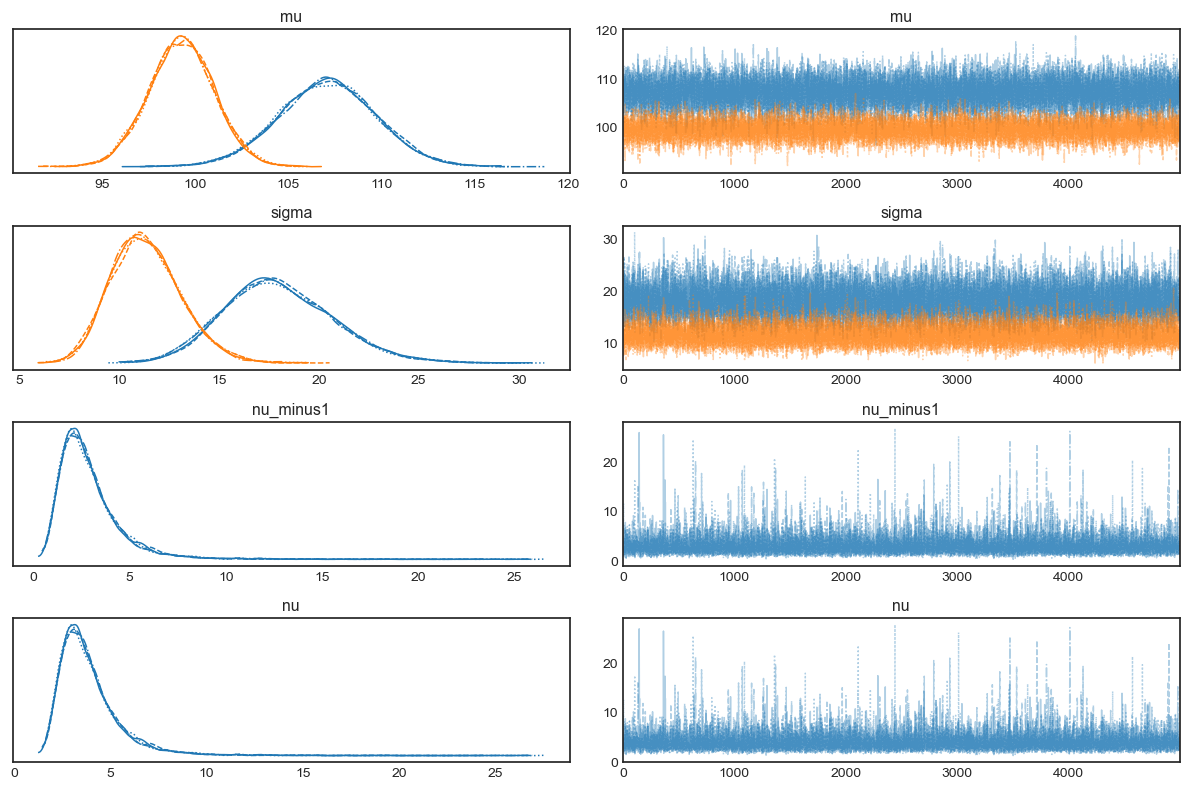

In [46]:
az.plot_trace(idata3)
plt.tight_layout();

In [47]:
(idata3
 .posterior['mu']
 .mean(dim = ['draw', 'chain'])
 .sel(group = 'Smart Drug')    
)

<xarray.DataArray 'mu' ()> Size: 8B
array(107.09457906)
Coordinates:
    group    <U10 40B 'Smart Drug'

In [49]:
(idata3
 .posterior['mu']
 .mean(dim = ['draw', 'chain'])
 .sel(group = 'Placebo')    
)

<xarray.DataArray 'mu' ()> Size: 8B
array(99.27197419)
Coordinates:
    group    <U10 40B 'Placebo'

In [50]:
# belief about the difference in location parameters (i.e., the unstandardized effect size)
(
    idata3.posterior["mu"].sel(group="Smart Drug")
    - idata3.posterior["mu"].sel(group="Placebo")
).mean()

<xarray.DataArray 'mu' ()> Size: 8B
array(7.82260487)

In [51]:
# probability smart drug group location > placebo group location
(
    idata3.posterior["mu"].sel(group="Smart Drug")
    > idata3.posterior["mu"].sel(group="Placebo")
).mean()

<xarray.DataArray 'mu' ()> Size: 8B
array(0.9922)